# Курс "Машинное обучение в бизнесе"

## Практическое задание урока 5. Задача оттока: варианты постановки, возможные способы решения

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности


### Решение

In [219]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import cross_val_score, train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

Работаем с набором данных с платформы kaggle https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers по оттоку клиентов банка

In [220]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить.

Посмотрим на распределение классов:

In [221]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Имеем распределение 1 к 4

Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [222]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

* Категориальные признаки закодируем с помощью OneHotEncoding
* Вещественные оставим пока как есть

In [223]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [224]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Зададим списки признаков

In [225]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Под каждый признак создаем трансформер и объединяем их в список (сделаем это в цикле, чтобы не мучиться).

Добавляем в cont_transformer стандартизацию вещественных признаков.

In [226]:
from sklearn.preprocessing import StandardScaler

final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())        
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [227]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

#### Модель RandomForestClassifier из урока 

In [228]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

In [229]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('Geography',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))],
                                                          verbose=False)),
                                                ('Gender',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                     

In [230]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.37, 0.26, 0.17, 0.02, 0.02, 0.67, 0.04, 0.12, 0.15, 0.75])

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [231]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, \
                            classification_report, precision_recall_curve, confusion_matrix

In [232]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.380000, F-Score=0.641, Precision=0.654, Recall=0.629


Отрисуем матрицу ошибок

In [233]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1833  158]
 [ 195  314]]


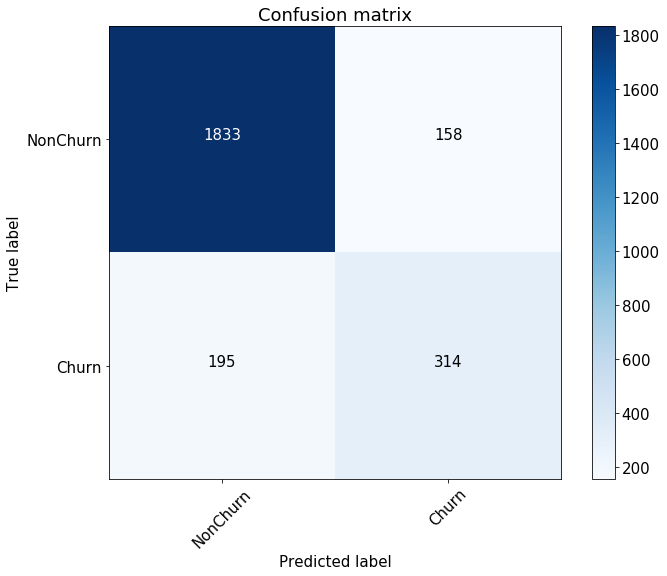

In [234]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [235]:
TP = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TN = cnf_matrix[1][1]

#### Вопрос 1: объясните своими словами смысл метрик Precison, Recall *
1. Какова их взаимосвязь и как с ними связан порог вероятности? 
2. Можно ли подобрать порог так, что recall будет равен 1? Что при этом будет с precision
3. Аналогичный вопрос про precision

***Ответ:***

1.Precision (точность) отражает какой процент объектов, отнесенных к основному классу, действительно являются таковыми. 

Recall (полнота) отражает какой процент объектов основного класса был обнаружен алгоритмом.

Precision = TP / (TP + FP)

Recall = TP / (TP + FN)

Между Precision и Recall имеется обратная зависимость. С ростом порога вероятности растет Precision, с уменьшением порога вероятности растет Recall.

2.Recall будет равен 1 при FN=0. Тогда порог вероятности должен быть минимальным. В этом случае все объекты основного класса правильно предсказаны. Отсутствует ошибка 2-го рода.

3.Precision будет равен 1 при FP=0. Тогда порог вероятности должен быть максимальным. В этом случае все предсказанные объекты основного класса фактически должны относиться к основному классу. Отсутствует ошибка 1-го рода.

<b>Вопрос 2: предположим, что на удержание одного пользователя у нас уйдет 1 доллар. При этом средняя ожидаемая прибыль с каждого TP (true positive) - 2 доллара. Оцените качество модели выше с учетом этих данных и ответьте на вопрос, является ли она потенциально экономически целесообразной?</b>

***Ответ:***

In [236]:
TP, FP, FN, TN

(1833, 158, 195, 314)

In [237]:
print(f'На отложенной выборке из {y_test.shape[0]} пользователей прибыль (убыток) составляет $ {2 * TP - (TP + FP)}')

На отложенной выборке из 2500 пользователей прибыль (убыток) составляет $ 1675


***Вывод:*** модель является потенциально экономически целесообразной.

<b>Задание 1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)<b>

In [238]:
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
# ------------------------------------------------------------------
frozen_params = {
    'eval_metric': 'F1',
    'auto_class_weights': 'Balanced',
    'silent': True,
    'one_hot_max_size': 20,
    'early_stopping_rounds': 50,
    'boosting_type': 'Ordered',
    'allow_writing_files': False
}

classifier_1 = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier(
    **frozen_params,
    depth=4,
    iterations=400,
    learning_rate=0.1,
    l2_leaf_reg=2.5,
    bagging_temperature=1.5
)),
])
# ------------------------------------------------------------------
classifier_2 = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])
# ------------------------------------------------------------------
classifier_3 = Pipeline([
    ('features',feats),
    ('classifier', LGBMClassifier(random_state = 42, silent=True)),
])

Обучим модели

In [239]:
# Функция обучения модели и расчета метрик
def get_metrics(classifier):
    #запустим кросс-валидацию
#    cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
#    cv_score = np.mean(cv_scores)
#    cv_score_std = np.std(cv_scores)

    #обучим пайплайн на всем тренировочном датасете
    classifier.fit(X_train, y_train)
    y_score = classifier.predict_proba(X_test)[:, 1]
    
    # расчтаем Precision, Recall, F_score, Roc auc
    b = 1
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (1 + b**2) * (precision * recall) / (b**2 * precision + recall)
    roc_auc = roc_auc_score(y_test, y_score)
    ix = np.argmax(fscore)
    
    # рассчитаем confusion matrix
#    tn, fp, fn, tp = confusion_matrix(y_test, preds > thresholds[ix]).ravel()
    
    cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])
     
    return roc_auc, precision[ix], recall[ix], fscore[ix], thresholds[ix], cnf_matrix

In [240]:
metrics = {'CatBoostClassifier': classifier_1, 
            'LogisticRegression': classifier_2,
            'LGBMClassifier': classifier_3
          }
info = pd.DataFrame(columns=metrics.keys())

In [241]:
%%time

for metric, value in metrics.items():
    print(metric, value)
    roc_auc, precision, recall, fscore, thresholds, cnf_matrix = get_metrics(value)
    info.loc[f'roc_auc', metric] = roc_auc
    info.loc[f'precision', metric] = precision
    info.loc[f'recall', metric] = recall
    info.loc[f'fscore', metric] = fscore
    info.loc[f'thresholds', metric] = thresholds
    info.loc[f'TP', metric] = cnf_matrix[0][0]
    info.loc[f'FP', metric] = cnf_matrix[0][1]
    info.loc[f'TN', metric] = cnf_matrix[1][0]
    info.loc[f'FN', metric] = cnf_matrix[1][1]

CatBoostClassifier Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('Geography',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))],
                                                          verbose=False)),
                                                ('Gender',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                  

<b>Задание 2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)<b>

In [242]:
info

,CatBoostClassifier,LogisticRegression,LGBMClassifier
roc_auc,0.877727,0.772077,0.870576
precision,0.636882,0.4624,0.660643
recall,0.658153,0.56778,0.646365
fscore,0.647343,0.5097,0.653426
thresholds,0.659165,0.289522,0.371377
TP,1970,1688,1822
FP,21,303,169
TN,328,145,189
FN,181,364,320


***Вывод:*** 
Наиболее подходящей DS-метрикой является Precision = TP / (TP + FP), исходя из оценки потенциальной экономической целесообразности по формуле 

profit = TP * 2 - (TP + FP) * 1 

Максимальная прибыль будет достигаться при максимальном значении TP и минимальном значении (TP+FP). 

По метрике Precision лучшей моделью является LGBMClassifier.

<b>Задание 3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.<b>

In [243]:
TP=info['LGBMClassifier'][5]
FP=info['LGBMClassifier'][6]
TN=info['LGBMClassifier'][7]
FN=info['LGBMClassifier'][8]
TP, FP, TN, FN

(1822, 169, 189, 320)

In [244]:
print(f'На отложенной выборке из {y_test.shape[0]} пользователей прибыль (убыток) составляет $ {2 * TP - (TP + FP)}')

На отложенной выборке из 2500 пользователей прибыль (убыток) составляет $ 1653


<b>Задание 4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3<b>

Создаем сетку с параметрами

In [245]:
from sklearn.model_selection import GridSearchCV

params={'classifier__num_leaves':[10, 15, 20],
        'classifier__lambda_l2':[200, 250, 300],
        'classifier__learning_rate':[0.01 , 0.05, 0.1],
        'classifier__n_jobs':[-1],
        'classifier__n_estimators':[300, 500, 1000, 2000],
        }

Запускаем перебор

In [246]:
%%time
grid = GridSearchCV(classifier_3,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will b

[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will b

[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will b

[LightGBM] [Warning] lambda_l2 is set=250, reg_lambda=0.0 will be ignored. Current value: lambda_l2=250
[LightGBM] [Warning] lambda_l2 is set=250, reg_lambda=0.0 will be ignored. Current value: lambda_l2=250
[LightGBM] [Warning] lambda_l2 is set=250, reg_lambda=0.0 will be ignored. Current value: lambda_l2=250
[LightGBM] [Warning] lambda_l2 is set=250, reg_lambda=0.0 will be ignored. Current value: lambda_l2=250
[LightGBM] [Warning] lambda_l2 is set=250, reg_lambda=0.0 will be ignored. Current value: lambda_l2=250
[LightGBM] [Warning] lambda_l2 is set=250, reg_lambda=0.0 will be ignored. Current value: lambda_l2=250
[LightGBM] [Warning] lambda_l2 is set=250, reg_lambda=0.0 will be ignored. Current value: lambda_l2=250
[LightGBM] [Warning] lambda_l2 is set=250, reg_lambda=0.0 will be ignored. Current value: lambda_l2=250
[LightGBM] [Warning] lambda_l2 is set=250, reg_lambda=0.0 will be ignored. Current value: lambda_l2=250
[LightGBM] [Warning] lambda_l2 is set=250, reg_lambda=0.0 will b

[LightGBM] [Warning] lambda_l2 is set=250, reg_lambda=0.0 will be ignored. Current value: lambda_l2=250
[LightGBM] [Warning] lambda_l2 is set=250, reg_lambda=0.0 will be ignored. Current value: lambda_l2=250
[LightGBM] [Warning] lambda_l2 is set=250, reg_lambda=0.0 will be ignored. Current value: lambda_l2=250
[LightGBM] [Warning] lambda_l2 is set=250, reg_lambda=0.0 will be ignored. Current value: lambda_l2=250
[LightGBM] [Warning] lambda_l2 is set=250, reg_lambda=0.0 will be ignored. Current value: lambda_l2=250
[LightGBM] [Warning] lambda_l2 is set=250, reg_lambda=0.0 will be ignored. Current value: lambda_l2=250
[LightGBM] [Warning] lambda_l2 is set=250, reg_lambda=0.0 will be ignored. Current value: lambda_l2=250
[LightGBM] [Warning] lambda_l2 is set=250, reg_lambda=0.0 will be ignored. Current value: lambda_l2=250
[LightGBM] [Warning] lambda_l2 is set=250, reg_lambda=0.0 will be ignored. Current value: lambda_l2=250
[LightGBM] [Warning] lambda_l2 is set=250, reg_lambda=0.0 will b

[LightGBM] [Warning] lambda_l2 is set=250, reg_lambda=0.0 will be ignored. Current value: lambda_l2=250
[LightGBM] [Warning] lambda_l2 is set=250, reg_lambda=0.0 will be ignored. Current value: lambda_l2=250
[LightGBM] [Warning] lambda_l2 is set=250, reg_lambda=0.0 will be ignored. Current value: lambda_l2=250
[LightGBM] [Warning] lambda_l2 is set=250, reg_lambda=0.0 will be ignored. Current value: lambda_l2=250
[LightGBM] [Warning] lambda_l2 is set=250, reg_lambda=0.0 will be ignored. Current value: lambda_l2=250
[LightGBM] [Warning] lambda_l2 is set=250, reg_lambda=0.0 will be ignored. Current value: lambda_l2=250
[LightGBM] [Warning] lambda_l2 is set=250, reg_lambda=0.0 will be ignored. Current value: lambda_l2=250
[LightGBM] [Warning] lambda_l2 is set=250, reg_lambda=0.0 will be ignored. Current value: lambda_l2=250
[LightGBM] [Warning] lambda_l2 is set=250, reg_lambda=0.0 will be ignored. Current value: lambda_l2=250
[LightGBM] [Warning] lambda_l2 is set=250, reg_lambda=0.0 will b

[LightGBM] [Warning] lambda_l2 is set=300, reg_lambda=0.0 will be ignored. Current value: lambda_l2=300
[LightGBM] [Warning] lambda_l2 is set=300, reg_lambda=0.0 will be ignored. Current value: lambda_l2=300
[LightGBM] [Warning] lambda_l2 is set=300, reg_lambda=0.0 will be ignored. Current value: lambda_l2=300
[LightGBM] [Warning] lambda_l2 is set=300, reg_lambda=0.0 will be ignored. Current value: lambda_l2=300
[LightGBM] [Warning] lambda_l2 is set=300, reg_lambda=0.0 will be ignored. Current value: lambda_l2=300
[LightGBM] [Warning] lambda_l2 is set=300, reg_lambda=0.0 will be ignored. Current value: lambda_l2=300
[LightGBM] [Warning] lambda_l2 is set=300, reg_lambda=0.0 will be ignored. Current value: lambda_l2=300
[LightGBM] [Warning] lambda_l2 is set=300, reg_lambda=0.0 will be ignored. Current value: lambda_l2=300
[LightGBM] [Warning] lambda_l2 is set=300, reg_lambda=0.0 will be ignored. Current value: lambda_l2=300
[LightGBM] [Warning] lambda_l2 is set=300, reg_lambda=0.0 will b

[LightGBM] [Warning] lambda_l2 is set=300, reg_lambda=0.0 will be ignored. Current value: lambda_l2=300
[LightGBM] [Warning] lambda_l2 is set=300, reg_lambda=0.0 will be ignored. Current value: lambda_l2=300
[LightGBM] [Warning] lambda_l2 is set=300, reg_lambda=0.0 will be ignored. Current value: lambda_l2=300
[LightGBM] [Warning] lambda_l2 is set=300, reg_lambda=0.0 will be ignored. Current value: lambda_l2=300
[LightGBM] [Warning] lambda_l2 is set=300, reg_lambda=0.0 will be ignored. Current value: lambda_l2=300
[LightGBM] [Warning] lambda_l2 is set=300, reg_lambda=0.0 will be ignored. Current value: lambda_l2=300
[LightGBM] [Warning] lambda_l2 is set=300, reg_lambda=0.0 will be ignored. Current value: lambda_l2=300
[LightGBM] [Warning] lambda_l2 is set=300, reg_lambda=0.0 will be ignored. Current value: lambda_l2=300
[LightGBM] [Warning] lambda_l2 is set=300, reg_lambda=0.0 will be ignored. Current value: lambda_l2=300
[LightGBM] [Warning] lambda_l2 is set=300, reg_lambda=0.0 will b

[LightGBM] [Warning] lambda_l2 is set=300, reg_lambda=0.0 will be ignored. Current value: lambda_l2=300
[LightGBM] [Warning] lambda_l2 is set=300, reg_lambda=0.0 will be ignored. Current value: lambda_l2=300
[LightGBM] [Warning] lambda_l2 is set=300, reg_lambda=0.0 will be ignored. Current value: lambda_l2=300
[LightGBM] [Warning] lambda_l2 is set=300, reg_lambda=0.0 will be ignored. Current value: lambda_l2=300
[LightGBM] [Warning] lambda_l2 is set=300, reg_lambda=0.0 will be ignored. Current value: lambda_l2=300
[LightGBM] [Warning] lambda_l2 is set=300, reg_lambda=0.0 will be ignored. Current value: lambda_l2=300
[LightGBM] [Warning] lambda_l2 is set=300, reg_lambda=0.0 will be ignored. Current value: lambda_l2=300
[LightGBM] [Warning] lambda_l2 is set=300, reg_lambda=0.0 will be ignored. Current value: lambda_l2=300
[LightGBM] [Warning] lambda_l2 is set=300, reg_lambda=0.0 will be ignored. Current value: lambda_l2=300
[LightGBM] [Warning] lambda_l2 is set=300, reg_lambda=0.0 will b

{'classifier__lambda_l2': 200,
 'classifier__learning_rate': 0.1,
 'classifier__n_estimators': 500,
 'classifier__n_jobs': -1,
 'classifier__num_leaves': 10}

Обучаем модель с новыми параметрами

In [247]:
classifier_4 = Pipeline([
    ('features',feats),
    ('classifier', LGBMClassifier(
        random_state = 42, silent=True, lambda_l2=200, 
        learning_rate=0.1, n_estimators=500, num_leaves=10, n_jobs=-1)),
])

In [248]:
metrics_best = {'LGBMClassifier': classifier_4 
          }
info_best = pd.DataFrame(columns=metrics_best.keys())

In [249]:
%%time

for metric, value in metrics_best.items():
    print(metric, value)
    roc_auc, precision, recall, fscore, thresholds, cnf_matrix = get_metrics(value)
    info_best.loc[f'roc_auc', metric] = roc_auc
    info_best.loc[f'precision', metric] = precision
    info_best.loc[f'recall', metric] = recall
    info_best.loc[f'fscore', metric] = fscore
    info_best.loc[f'thresholds', metric] = thresholds
    info_best.loc[f'TP', metric] = cnf_matrix[0][0]
    info_best.loc[f'FP', metric] = cnf_matrix[0][1]
    info_best.loc[f'TN', metric] = cnf_matrix[1][0]
    info_best.loc[f'FN', metric] = cnf_matrix[1][1]

LGBMClassifier Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('Geography',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))],
                                                          verbose=False)),
                                                ('Gender',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                      

In [250]:
info_best

,LGBMClassifier
roc_auc,0.874355
precision,0.643287
recall,0.630648
fscore,0.636905
thresholds,0.399532
TP,1838
FP,153
TN,199
FN,310


<b>Задание 5. (опционально) Еще раз провести оценку экономической эффективности<b>

In [251]:
TP=info_best['LGBMClassifier'][5]
FP=info_best['LGBMClassifier'][6]
TN=info_best['LGBMClassifier'][7]
FN=info_best['LGBMClassifier'][8]
TP, FP, TN, FN

(1838, 153, 199, 310)

In [252]:
print(f'На отложенной выборке из {y_test.shape[0]} пользователей прибыль (убыток) составляет $ {2 * TP - (TP + FP)}')

На отложенной выборке из 2500 пользователей прибыль (убыток) составляет $ 1685


Экономическая эффективность повысилась в результате подбора гиперпараметров лучшей модели по иогам п.2-3.